<a href="https://colab.research.google.com/github/brianhphillips/testrepo/blob/main/EconomicIndicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install -q statsmodels linearmodels pandas matplotlib seaborn openpyxl

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
file_path = '/content/drive/My Drive/Economic Indicators.csv'
df = pd.read_csv(file_path)

# Convert date string to datetime and set index
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df = df.asfreq('AS')  # Set annual frequency

Mounted at /content/drive


<ipython-input-2-a751d9b901f2>:11: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df = df.asfreq('AS')  # Set annual frequency


In [3]:
x_var = 'TotalFederalDebt'
y_vars = [
    'RealGDP', 'RealGDPPerCapita', 'CPIUrban', 'SavingsRate',
    'TotalLFPR', 'LFPRWorkingAge', 'LFPRMen', 'LFPRRetirementAge',
    'LFPRTeenage', 'LFPRCollegeAge', 'Unemployment', 'RealExports',
    'RealImports', 'NetExports', 'DepositoryReserves', 'GDPRnD'
]

df = df[[x_var] + y_vars].dropna()

In [4]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"{name}: p-value = {result[1]:.4f} {'(stationary)' if result[1] < 0.05 else '(non-stationary)'}")

for col in [x_var] + y_vars:
    adf_test(df[col], col)

TotalFederalDebt: p-value = 1.0000 (non-stationary)
RealGDP: p-value = 1.0000 (non-stationary)
RealGDPPerCapita: p-value = 0.9939 (non-stationary)
CPIUrban: p-value = 0.9978 (non-stationary)
SavingsRate: p-value = 0.1196 (non-stationary)
TotalLFPR: p-value = 0.0018 (stationary)
LFPRWorkingAge: p-value = 0.1731 (non-stationary)
LFPRMen: p-value = 0.9292 (non-stationary)
LFPRRetirementAge: p-value = 0.1835 (non-stationary)
LFPRTeenage: p-value = 0.8732 (non-stationary)
LFPRCollegeAge: p-value = 0.2251 (non-stationary)
Unemployment: p-value = 0.0065 (stationary)
RealExports: p-value = 0.7599 (non-stationary)
RealImports: p-value = 0.9842 (non-stationary)
NetExports: p-value = 0.9569 (non-stationary)
DepositoryReserves: p-value = 0.9791 (non-stationary)
GDPRnD: p-value = 1.0000 (non-stationary)


In [5]:
df_diff = df.diff().dropna()

In [6]:
def local_projection(df, x_var, y_var, lags=1, horizon=10):
    df_lp = df.copy()
    df_lp['X_lag'] = df_lp[x_var].shift(lags)
    df_lp.dropna(inplace=True)

    betas = []
    lower, upper = [], []

    for h in range(1, horizon + 1):
        df_lp[f'{y_var}_lead'] = df_lp[y_var].shift(-h)
        model_df = df_lp[[f'{y_var}_lead', 'X_lag']].dropna()
        model_df = add_constant(model_df)

        model = OLS(model_df[f'{y_var}_lead'], model_df[['const', 'X_lag']]).fit()
        betas.append(model.params['X_lag'])
        conf = model.conf_int().loc['X_lag']
        lower.append(conf[0])
        upper.append(conf[1])

    return betas, lower, upper

In [7]:
def plot_irf(betas, lower, upper, y_var):
    horizon = len(betas)
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, horizon + 1), betas, label='IRF')
    plt.fill_between(range(1, horizon + 1), lower, upper, color='lightblue', alpha=0.5, label='95% CI')
    plt.title(f'Effect of {x_var} on {y_var}')
    plt.xlabel('Years After Shock')
    plt.ylabel('Response')
    plt.axhline(0, color='black', linewidth=0.7)
    plt.legend()
    plt.grid(True)
    plt.show()

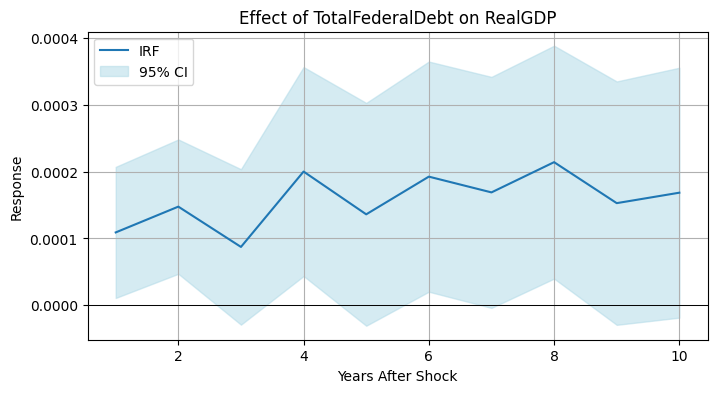

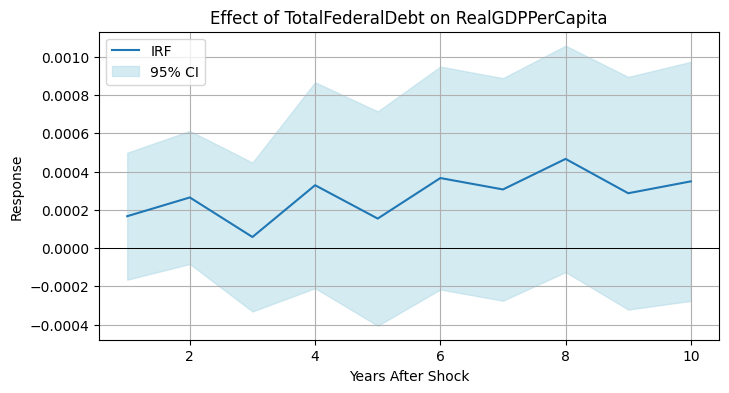

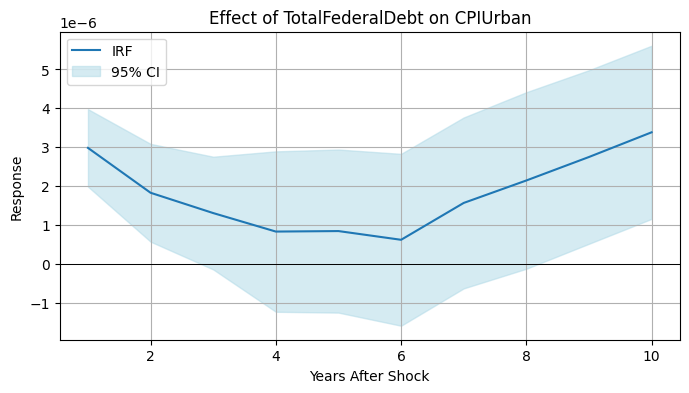

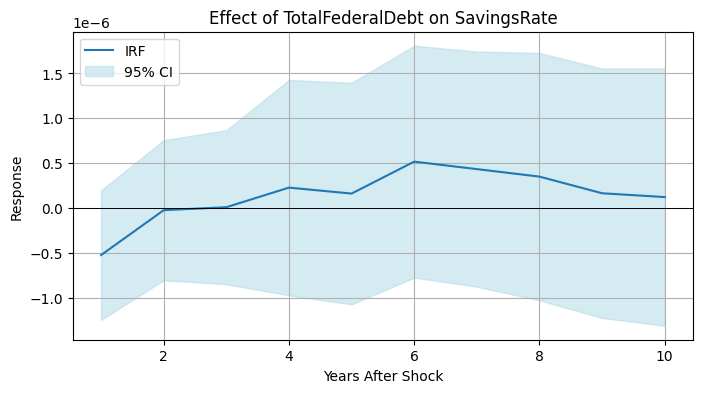

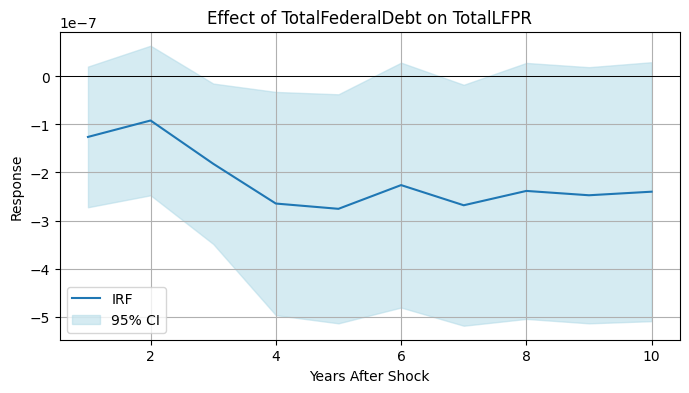

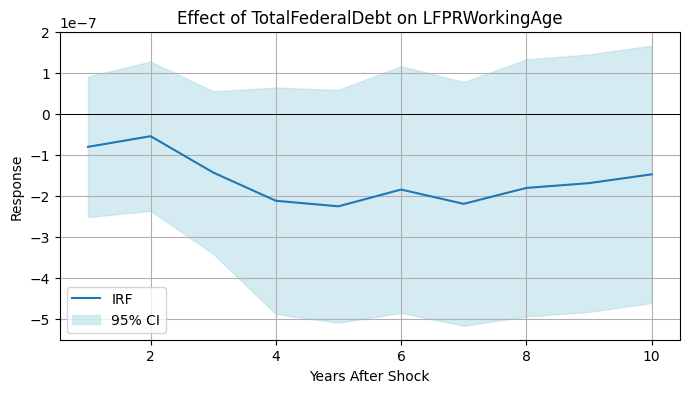

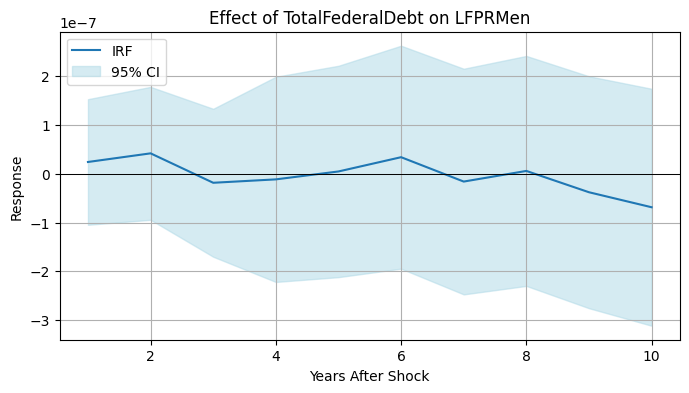

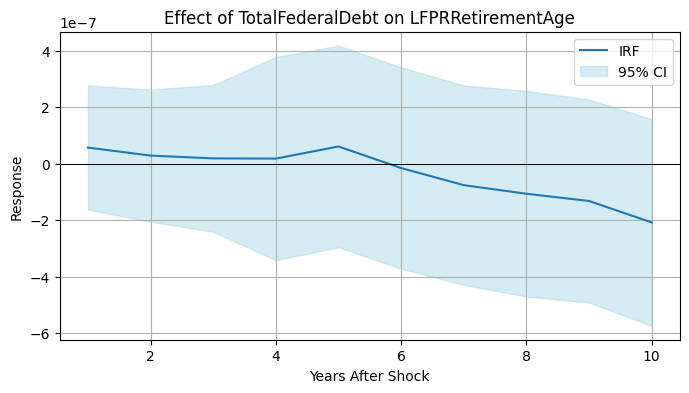

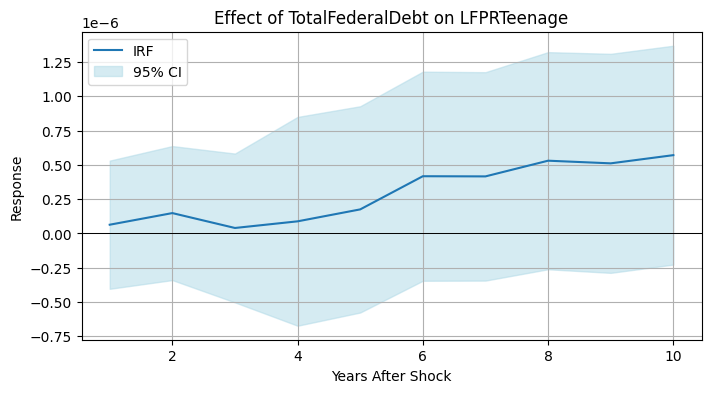

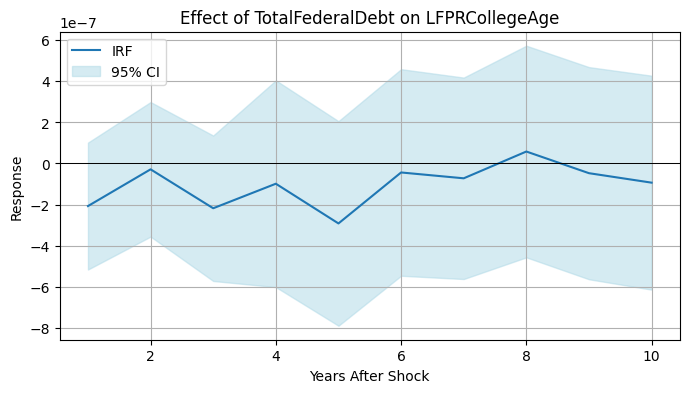

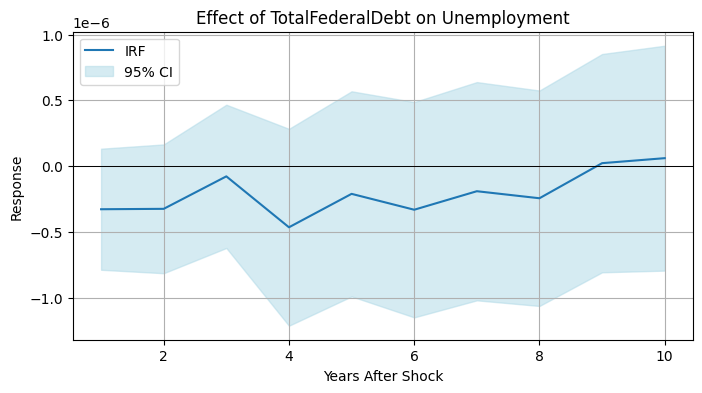

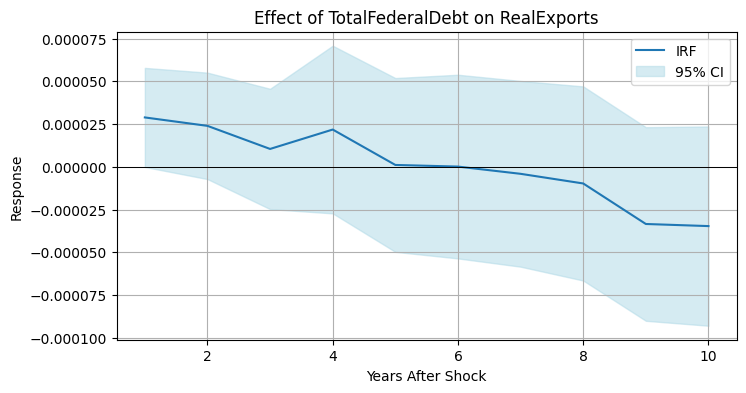

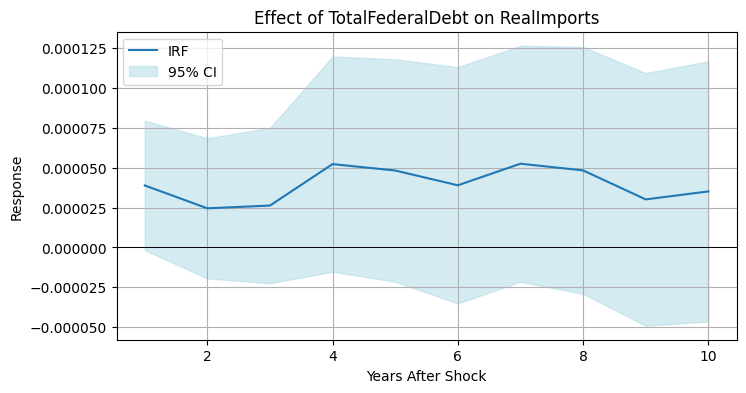

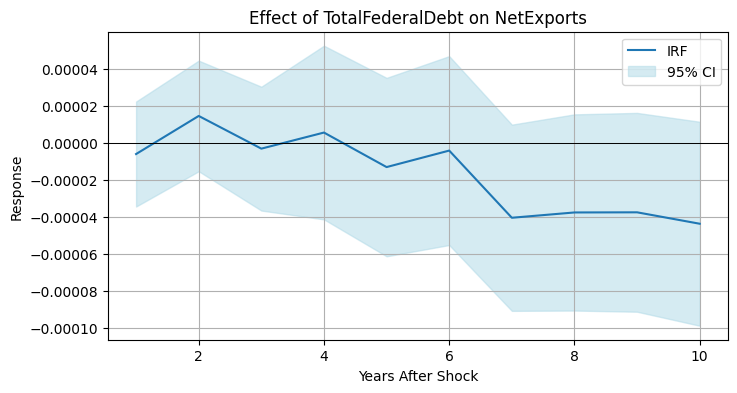

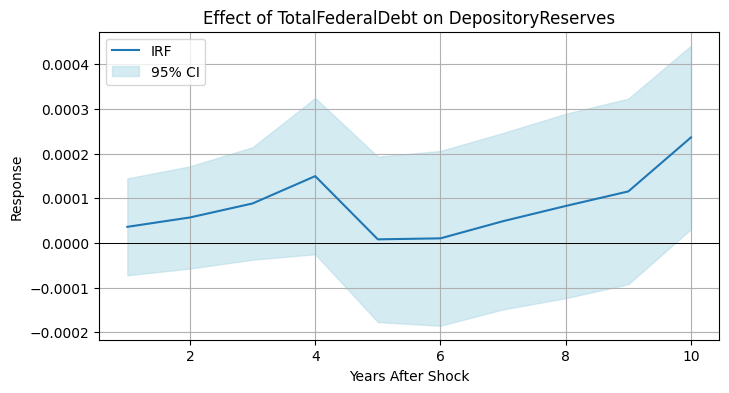

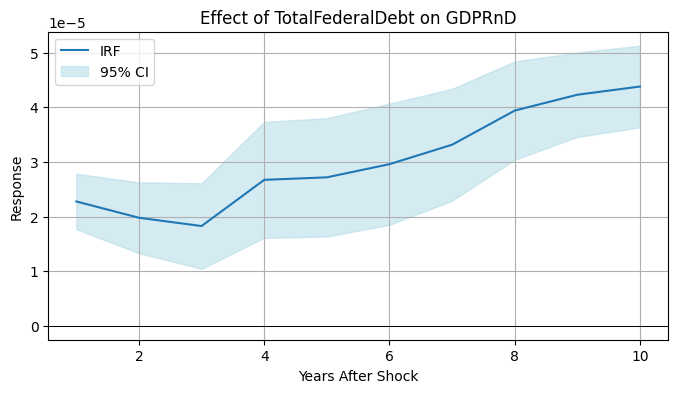

In [8]:
for y in y_vars:
    betas, lower, upper = local_projection(df_diff, x_var, y)
    plot_irf(betas, lower, upper, y)